<a href="https://colab.research.google.com/github/joshuadollison/MAT421/blob/main/MAT421_16133_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Portfolio Optimization via PCA**

## **Final Project**

Joshua Dollison

MAT421-16133

4/27/2025

## 1. INTRODUCTION

Managing portfolio risk is central to finance and investment strategy.  In modern finance, investors often face the challenge of constructing portfolios from large sets of correlated assets.  Constructing a diversified equity portfolio requires understanding not only individual asset risk but also the complex web of correlations among assets.

As investors build diversified portfolios of dozens or hundreds of stocks, analyzing the joint behavior of asset returns becomes complex due to high correlations among the assets.  As the number of holdings grows, simple pairwise correlation analysis becomes unwieldy and may mask the true underlying drivers of portfolio risk.  High-dimensional correlation structures make it difficult to identify true underlying market factors and to diversify effectively.  

Principal Component Analysis (PCA) is a statistical technique that addresses this challenge by transforming a set of possibly correlated variables into a smaller number of uncorrelated components that capture the majority of the variance in the data.  PCA offers a systematic way to reduce dimensionality by transforming correlated return series into a smaller set of orthogonal factors (principal components) that capture the bulk of the total variance.  These components can be interpreted as latent “market” or “sector” risk factors, enabling clearer risk budgeting and more efficient portfolio construction.

The goal of this project is to apply PCA to historical daily stock returns from a selected basket of equities (e.g., S&P 500 subset) to identify dominant patterns in market behavior and reduce dimensionality. By analyzing the eigenstructure of the return covariance matrix, we aim to identify dominant market factors, construct eigenportfolios, and ultimately inform portfolio optimization decisions.  This approach provides insights into latent market factors (e.g., overall market trend, sector performance) and helps in understanding systemic risk exposures.

## 2. MATH METHOD

Principal Component Analysis (PCA) is a technique for uncovering the most important patterns of variation in a high-dimensional dataset. In finance, these patterns correspond to latent “risk factors” that drive groups of asset returns.

---

### 2.1 From Returns to Covariance

1. **Log returns**  
   We begin with an $n\times T$ matrix $R$ of daily log returns, where  
   $$R_{i,t} = \ln\bigl(P_{i,t}/P_{i,t-1}\bigr).$$  
   Log-returns are additive over time and symmetrize positive/negative moves.

2. **Centering & Standardization**  
   For each asset $i$, compute its sample mean $\bar r_i$ and standard deviation $s_i$. Then define  
   $$\tilde R_{i,t} = \frac{R_{i,t} - \bar r_i}{s_i},$$  
   so that each row of $\tilde R$ has zero mean and unit variance.

3. **Covariance matrix**  
   The covariance structure of these standardized returns is captured by  
   $$\Sigma = \frac{1}{T-1}\,\tilde R\,\tilde R^\top,$$  
   an $n\times n$ symmetric matrix whose $(i,j)$ element is the correlation-adjusted covariance between assets $i$ and $j$.

---

### 2.2 Eigen-Decomposition

PCA finds an orthonormal basis in which $\Sigma$ becomes diagonal:

$$
\Sigma\,v_k = \lambda_k\,v_k,
\quad k=1,\dots,n,
$$

- $\lambda_1\ge\lambda_2\ge\cdots\ge\lambda_n\ge0$ are the eigenvalues, each indicating how much variance lies along that direction.  
- $v_k$ are the corresponding eigenvectors (principal directions), with $\|v_k\|=1$ and $v_k^\top v_\ell=0$ for $k\neq\ell$.

Define the explained-variance ratio of component $k$ by

$$
\alpha_k = \frac{\lambda_k}{\sum_{j=1}^n \lambda_j},
\qquad
\sum_{k=1}^n \alpha_k = 1.
$$

The cumulative explained variance by the first $m$ components is
$$
\sum_{k=1}^m \alpha_k.
$$
In practice we choose the smallest $m$ such that this sum exceeds some threshold (e.g. 70%).

---

### 2.3 Interpreting Components as Portfolios

Each eigenvector $v_k$ can be viewed as a weight vector for an “eigenportfolio”:

$$
w^{(k)} = \frac{v_k}{\mathbf{1}^\top v_k}
\quad\text{(normalized so that $\sum_i w_i^{(k)}=1$)}.
$$

Projecting the standardized returns onto $v_k$,

$$
f_k(t) = v_k^\top\,\tilde R_{\cdot,t},
$$

yields the time series of that factor. Economically:

- PC1 captures the common market mode (the direction in which most stocks move together).  
- PC2, PC3, … capture successively smaller “sectoral” or idiosyncratic risk modes (e.g. energy vs. tech, defensive vs. cyclical, TSLA-specific swings).

By reconstructing returns using only the top $m$ PCs,

$$
\tilde R_{\mathrm{approx}}
= \sum_{k=1}^m f_k\,v_k^\top,
$$

we achieve a low-dimensional representation that explains the bulk of portfolio risk, greatly simplifying optimization, hedging, or visualization tasks.

---

**How this applies to our portfolio problem:**  
We take our basket of 10 stocks, compute their standardized return covariance, and perform PCA to:

1. **Identify** the dominant sources of common variation (“market,” “sector,” “idiosyncratic”).  
2. **Quantify** how many latent factors suffice (e.g. 3 PCs → ≈ 70% variance).  
3. **Construct** eigenportfolios that can serve as factor-based building blocks for risk-parity or hedged allocations.  
4. **Reduce** the dimensionality of the allocation problem while retaining interpretability—crucial when dealing with a large universe of assets.

## 3. IMPLEMENTATION

Below is a Python implementation using **pandas**, **numpy**, **scikit-learn**, and **yfinance**.

We will carry out the following steps in code:

1. **Data Acquisition** – fetch price data  
2. **Exploratory Data Analysis (EDA)** – preview & stats  
3. **Return Calculation** – compute log returns  
4. **Standardization** – scale returns to unit variance  
5. **PCA Fit** – extract components and variance explained  
6. **Visualization** – scree plot, heatmaps, loading charts  

### 3.1 Data Acquisition

In this subsection, we fetch historical adjusted-close price data for our selected equities using the `yfinance` library.  

We chose a diversified list of 10 tickers spanning Technology (AAPL, MSFT, GOOGL, AMZN), Financials (JPM, V), Energy (XOM), Healthcare (JNJ), and Consumer Goods (PG, TSLA).  

We use `auto_adjust=True` to automatically account for corporate actions (splits, dividends), ensuring our price series reflect total returns.  

The downloaded data is stored in a pandas DataFrame named `prices`.  

We display the first five rows to verify the download was successful, inspect column labels, and confirm there are no missing or malformed entries.

In [1]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL','MSFT','GOOGL','AMZN','JPM','XOM','JNJ','V','PG','TSLA']
data = yf.download(
    tickers,
    start='2018-01-01',
    end='2023-12-31',
    auto_adjust=True
)
prices = data['Close']
prices.head()

[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,PG,TSLA,V,XOM
Date,,,,,,,,,,
2018-01-02,40.479839,59.450500,53.405170,113.850296,87.571877,79.474159,74.359985,21.368668,108.921021,60.593185
2018-01-03,40.472790,60.209999,54.316319,114.937859,87.661102,79.844017,74.269753,21.150000,110.005386,61.783245
2018-01-04,40.660774,60.479500,54.527306,114.929642,88.916901,80.546745,74.794746,20.974667,110.414406,61.868782
2018-01-05,41.123722,61.457001,55.250351,115.878212,88.346100,81.545418,74.843964,21.105333,113.058723,61.818913
2018-01-08,40.970978,62.343498,55.445415,116.025406,88.476570,81.628609,75.237717,22.427334,113.515282,62.096809


### 3.2 Exploratory Data Analysis

#### 3.2.1 Descriptive Statistics

After loading the price data, we review basic summary statistics for each security—mean, standard deviation, minimum, maximum, and quartiles.

These metrics help us understand overall price levels, dispersion, and detect any anomalies or outliers (e.g., erroneous spikes).  

We use `prices.describe().T` so that each row corresponds to a ticker, making cross-asset comparison straightforward.

In [2]:
prices.describe().T

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,1509.0,108.193114,51.108264,33.915249,51.412632,120.876648,150.734482,196.927689
AMZN,1509.0,120.070903,33.408177,59.450500,90.698997,114.302002,154.474503,186.570496
GOOGL,1509.0,90.757906,31.199323,48.999241,59.934456,87.601173,119.130447,149.125534
JNJ,1509.0,135.274609,19.596817,96.589058,116.708176,137.057465,152.460312,170.243515
JPM,1509.0,112.774345,22.999416,68.061722,91.445648,109.532501,134.683716,164.460587
MSFT,1509.0,207.084306,83.451595,78.604988,128.269379,214.428024,276.177551,379.099365
PG,1509.0,113.785088,26.392277,59.178146,95.669823,121.740929,135.356506,151.527390
TSLA,1509.0,145.981504,113.530192,11.931333,22.271334,160.190002,242.190002,409.970001
V,1509.0,187.426665,37.391249,108.302765,160.356171,195.713181,217.281326,259.952271


We can make the following observations:

- Absolute price levels
    - Highest mean: V (187 USD), MSFT (207 USD), TSLA (146 USD), JNJ (135 USD).
    - Lowest mean: XOM (64 USD), GOOGL (91 USD), AAPL (108 USD).
- Volatility (std)
    - Most volatile: TSLA (113.5 USD) and MSFT (83.5 USD) show huge swings.
    - Most stable: JNJ (19.6 USD), XOM (23.0 USD), AMZN (33.4 USD).
- Skew & outliers
    -  TSLA's minimum of 11.93 vs maximum of 409.97 indicates extreme right-tail events—reflecting the stock's rapid rises/falls.
    - MSFT's range (≈ 78.6-379.1) also underscores big moves over the window.
- Quartile spreads
    - TSLA IQR (Q3-Q1 = 242.2-22.3 ≈ 220 USD) dwarfs all others.
    - Defensive names like JNJ and PG have much tighter IQRs (≈ 35 USD and 40 USD respectively), consistent with steadier businesses.
- Median vs mean
    - AAPL median (120.9) > mean (108.2) and TSLA median (160.2) > mean (146.0) both hint at right-skew (outlier highs).
    - PG and JNJ show medians and means very close, indicating a more symmetric distribution.

#### 3.2.2 Price Correlation

Raw price levels often move together due to broad market trends.

Here, we compute the correlation matrix of daily percentage changes (`prices.pct_change().corr()`) to assess how returns co-move.  

Plotting this matrix as a heatmap highlights which pairs of assets have the strongest positive or negative relationships, guiding our interpretation of later PCA factors.

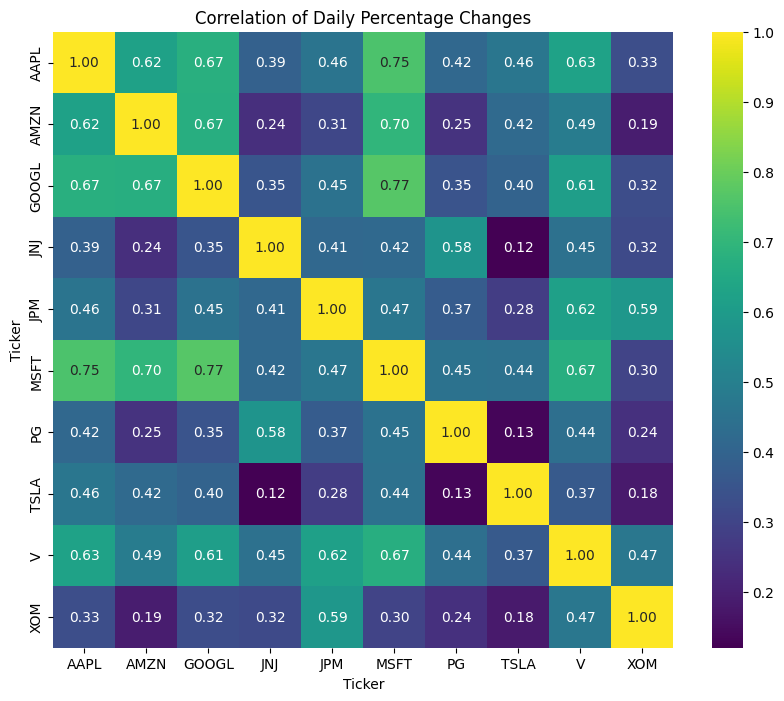

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(prices.pct_change().corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation of Daily Percentage Changes')
plt.show()

### 3.3 Return Calculation

#### 3.3.1 Compute

We convert adjusted closing prices into daily log returns via:

```python
log_returns = np.log(prices / prices.shift(1)).dropna()
```

Log returns are time-additive and handle large moves symmetrically, making them preferred for statistical analysis.

We preview the first few rows of log_returns to confirm correct computation and date alignment.

In [4]:
import numpy as np
log_returns = np.log(prices / prices.shift(1)).dropna()
log_returns.head()

Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,MSFT,PG,TSLA,V,XOM
Date,,,,,,,,,,
2018-01-03,-0.000174,0.012694,0.016917,0.009507,0.001018,0.004643,-0.001214,-0.010286,0.009906,0.019450
2018-01-04,0.004634,0.004466,0.003877,-0.000071,0.014224,0.008763,0.007044,-0.008325,0.003711,0.001384
2018-01-05,0.011321,0.016033,0.013173,0.008220,-0.006440,0.012322,0.000658,0.006210,0.023667,-0.000806
2018-01-08,-0.003721,0.014322,0.003524,0.001269,0.001476,0.001020,0.005247,0.060755,0.004030,0.004485
2018-01-09,-0.000115,0.004665,-0.001275,0.015733,0.005057,-0.000680,-0.007332,-0.008118,-0.001929,-0.004255


#### 3.3.2 Return Statistics & Correlation

Descriptive statistics of log returns (`log_returns.describe().T`) reveal each asset’s average return and volatility (standard deviation).  

These numbers set expectations for risk and return.

In [5]:
log_returns.describe().T

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
AAPL,1508.0,0.001030,0.019965,-0.137708,-0.008296,0.001175,0.011825,0.113157
AMZN,1508.0,0.000622,0.022280,-0.151398,-0.010492,0.001219,0.012166,0.126949
GOOGL,1508.0,0.000634,0.019696,-0.123685,-0.008542,0.000980,0.010948,0.091852
JNJ,1508.0,0.000186,0.012763,-0.105781,-0.005537,0.000400,0.006333,0.076940
JPM,1508.0,0.000417,0.019179,-0.162106,-0.008308,0.000470,0.009279,0.165620
MSFT,1508.0,0.001024,0.018980,-0.159453,-0.008094,0.001316,0.010904,0.132929
PG,1508.0,0.000425,0.013128,-0.091428,-0.005560,0.000765,0.007026,0.113409
TSLA,1508.0,0.001627,0.040116,-0.236518,-0.018421,0.001767,0.020698,0.181445
V,1508.0,0.000572,0.017366,-0.145571,-0.007509,0.001451,0.008935,0.129647


#### 3.3.3 Correlation

We then recompute and visualize the correlation matrix of log returns to focus purely on co-movement patterns independent of price-level trends.  

This return-level correlation is the core input structure that PCA will decompose.

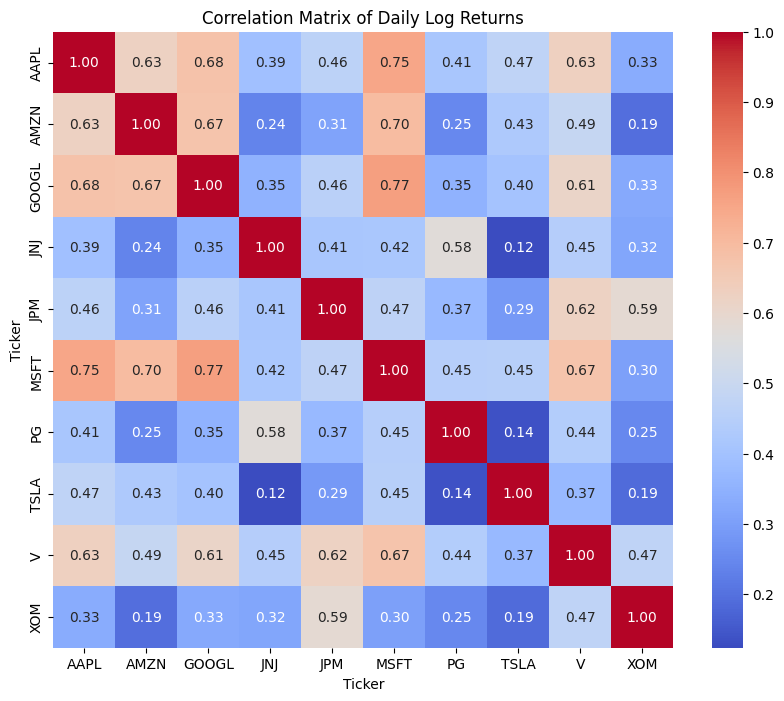

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(log_returns.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Daily Log Returns')
plt.show()

### 3.4 Standardization

PCA assumes all inputs are on the same scale.  
We standardize the log-return matrix to zero mean and unit variance with:

```python
scaler = StandardScaler()
R_std = scaler.fit_transform(log_returns)
```

This prevents assets with larger raw volatility from dominating the principal components solely due to scale differences.

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
R_std = scaler.fit_transform(log_returns)

### 3.5 PCA Computation

We fit a PCA model on the standardized return matrix `R_std`:

```python
pca = PCA()
pca.fit(R_std)
explained = pca.explained_variance_ratio_
```
The array explained holds the fraction of total variance captured by each successive component.

In [8]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(R_std)
explained = pca.explained_variance_ratio_

### 3.6 Visualization

#### 3.6.1 Scree Plot

A scree plot shows cumulative variance explained as we include more components:

```python
plt.plot(np.cumsum(explained), marker='o')
plt.axhline(0.70, linestyle='--', label='70% threshold')
```

The horizontal line at 70% helps us choose the minimal number of PCs needed to capture the majority of systemic risk.

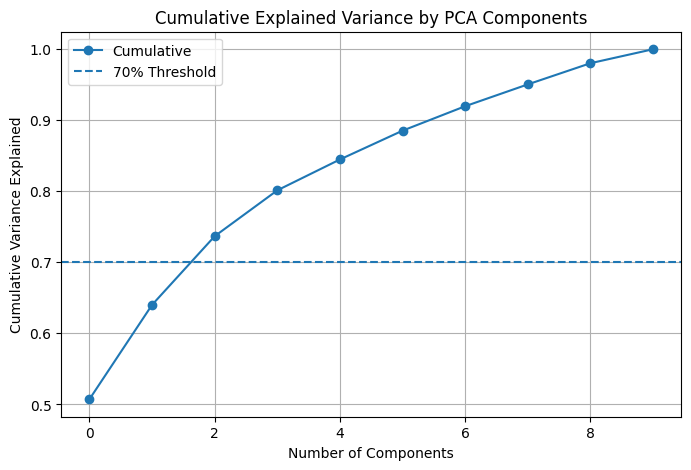

In [9]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(explained), marker='o', label='Cumulative')
plt.axhline(0.70, linestyle='--', label='70% Threshold')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

We can observe the following:

- First Component Dominance
    - PC1 alone captures about 50.7% of the total variance. That means over half of all daily return variability across your ten stocks moves together in a single “market” direction.
- Marginal Gain from Additional PCs
    - PC2 brings the cumulative up to ≈ 64.0% (≈ 13.3% incremental).
    - PC3 pushes you past the 70% threshold (≈ 73.5% cumulative), adding another ≈ 9.5%.
    - Beyond PC3, each extra component explains progressively less (PC4 adds ≈ 4.9%, PC5 ≈ 4.4%, etc.), indicating diminishing returns for dimensionality.
- Practical Cutoff
    - If your goal is to capture ~70% of the market's co-movement, you need only the first three PCs. Using more factors (4th, 5th…) will fine-tune but at the cost of complexity.

#### 3.6.2 Component Loadings

To interpret the first principal component, we examine its loadings (`pca.components_[0]`).  
Each loading represents a security's contribution to this dominant risk factor.  

Plotting these loadings as a bar chart clarifies which stocks drive overall market movements and suggests sectoral or idiosyncratic influences.

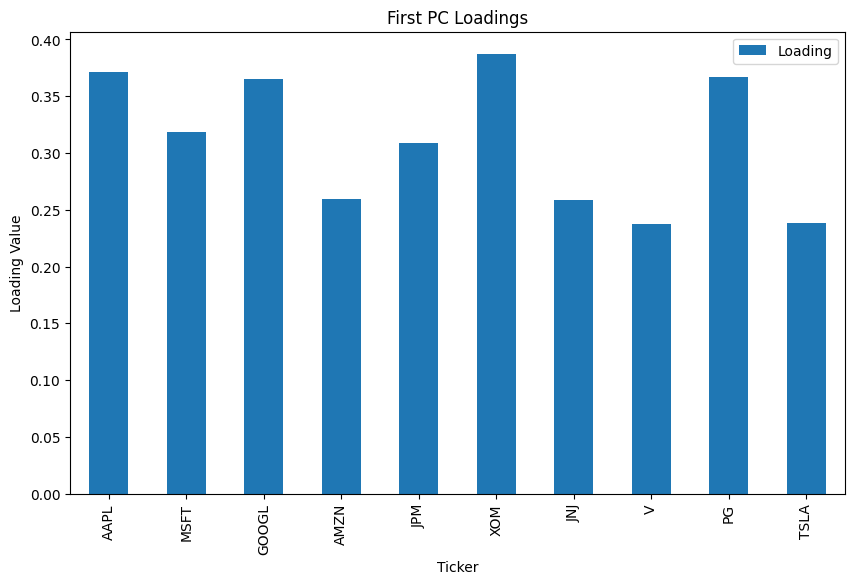

In [15]:
loadings = pca.components_[0]
import pandas as pd
loading_df = pd.DataFrame({'Ticker': tickers, 'Loading': loadings})
loading_df.set_index('Ticker').plot(kind='bar', figsize=(10,6))
plt.title('First PC Loadings')
plt.ylabel('Loading Value')
plt.show()

Each bar is the weight (loading) of that stock in PC1.  We can make the following observations:

- Broad “Market” Factor
    - Almost every stock loads positively, confirming PC1 is a general market-wide risk factor.
- Heaviest Contributors
    - XOM (0.39) has the largest weight, surprisingly showing that energy co-moves very tightly with the general market in this period.
    - AAPL, PG, GOOGL each contribute ~0.37, making them the next strongest market indicators.
- Moderate Contributors
    - MSFT (0.32) and JPM (0.31) sit in the middle—still heavily tied to the market but slightly less so than the top four.
- Lower Loadings = More Idiosyncratic
    - AMZN, JNJ, V, TSLA (≈ 0.24-0.26) have the smallest weights. These names carry a bit more stock-specific noise (e.g., TSLA's product announcements, JNJ's pharma news) that isn't fully explained by the broad market mode.

### Conclusion

We can think of PC1 as your “portfolio beta” exposure. The heavyweights are the stocks you'd tilt toward if you wanted maximum market-direction sensitivity; the lightweights are the ones you'd lean on if you wanted something a bit more uncorrelated with broad market swings.

## 4. DATA
- **Source**: yfinance adjusted-close prices.  
- **Period**: Jan 2018–Dec 2023.  
- **Assets**: 10 tickers spanning multiple sectors.

## 5. REFERENCES
- Connor, G. & Korajczyk, R. (1986). *Performance Measurement with the Arbitrage Pricing Theory*. Journal of Financial Economics.  
- Jolliffe, I.T. (2002). *Principal Component Analysis*, 2nd Ed., Springer.
- OpenAI. (2025). ChatGPT GPT-4o. https://chatgpt.com/.  
- Scikit-learn PCA documentation: https://scikit-learn.org/stable/modules/decomposition.html#pca  
- yfinance documentation: https://pypi.org/project/yfinance/